In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


In [2]:
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop, Resize
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
# dataset_unfiltered = datasets.load_dataset("timm/imagenet-1k-wds")
# dataset_size_filtered = dataset_unfiltered.filter(lambda s : s['jpg'].mode == 'RGB' and s['jpg'].width>=240 and s['jpg'].height>=240)
# dataset_no_decode = dataset_size_filtered.cast_column('jpg',datasets.Image(decode=False))
# dataset_quality_filtered = dataset_no_decode.filter(lambda s: len(s['jpg']['bytes'])>20000)
# dataset = dataset_quality_filtered.cast_column('jpg',datasets.Image(decode=True))
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [4]:
config = SimpleNamespace()
config.F = 8
config.latent_dim = 12;
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.epochs = 100
config.progressive_sizes = [32*int(s) for s in 2**(np.linspace(2,3.95,config.epochs))];
config.batch_size = 16
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(f"(start res, end_res) {(config.progressive_sizes[0], config.progressive_sizes[-1])}")

(start res, end_res) (128, 480)


In [5]:
model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

4.928796 M parameters


In [6]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def collate_fn(batch, epoch):
    img_size = get_epoch_size(epoch)
    tensor_list = []
    for sample in batch:
        processed = pil_to_tensor(RandomCrop(img_size)(Resize(img_size)(sample['image']))).unsqueeze(0)
        tensor_list.append(processed)
    return torch.cat(tensor_list, dim=0).to(torch.float) / 127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, f'checkpoint_f{config.F}c{config.latent_dim}.pth')

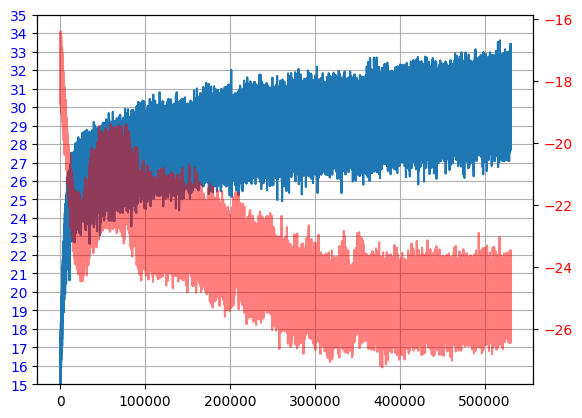

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [10]:
torch.save({
    'config': config,
    'state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict()
}, 'rgb_f8c12.pth')

26.898 KB
29.23756413116217x compression ratio
16.0x dimension reduction
28.765870642344566 dB PSNR


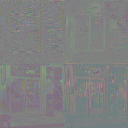

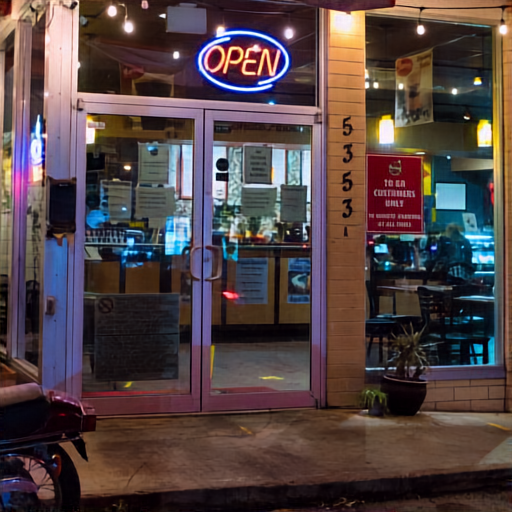

In [25]:
model.eval()
img = dataset['validation'][28]['image'].crop((768,512,1280,1024))
x = pil_to_tensor(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)[0]

buff = io.BytesIO()
webp.save(buff, format='WEBP',lossless=True)
webp = PIL.Image.open(buff)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")

latent_decoded = pil_to_latent([webp], N=config.latent_dim, n_bits=8, C=3).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)
    x_hat = x_hat.clamp(-1,1)

mse = torch.nn.functional.mse_loss(x_orig, x_hat[0])
PSNR = -10 * mse.log10().item() + 20*np.log10(2)
print(f"{PSNR} dB PSNR")

display(webp)
display(to_pil_image(x_hat[0].clamp(-1, 1) / 2 + 0.5))